# Bayesian Anova

In [1]:
import pandas as pd
import numpy as np
import pymc as pm

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

sns.set_theme()

## Data Collection & Analysis

In [2]:
data = pd.read_csv("datasets/Assignment 1 data.csv")
data = data.sort_values("treatment")

x = data["treatment"].to_numpy()
no_treatments = len(x)

clarity = data["clarity"].to_numpy()
viscosity = data["viscosity"].to_numpy()

mean_viscosity = np.mean(viscosity)
mean_clarity = np.mean(clarity)

[Text(0, 0, 'Base + Honey'),
 Text(1, 0, 'Base + Stevia'),
 Text(2, 0, 'Base + Sucralose'),
 Text(3, 0, 'Base + Sugar'),
 Text(4, 0, 'Control')]

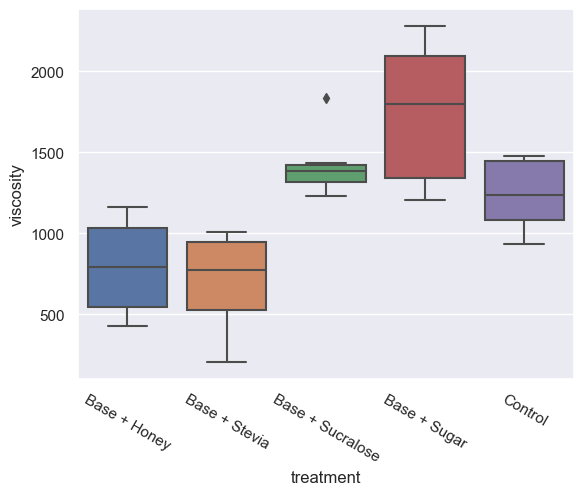

In [3]:
g = sns.boxplot(x="treatment", y="viscosity", data=data)
g.set_xticklabels(g.get_xticklabels(), rotation=-30)

Standard deviation in groups

In [4]:
X, factors = pd.factorize(data["treatment"])

## Model Viscosity - Common Variance
### Model Specification
Centered parameterization

$$ \phi \sim N(0, 100) , \tau_\theta \sim Exp(1) $$
$$ \theta_i \sim N(\phi, 1/\tau_\theta) $$
$$ \tau_y \sim Exp(1) $$
$$ \hat{y}_i | \theta_i, \tau_y \sim N(\theta_i, 1/\tau_y)$$


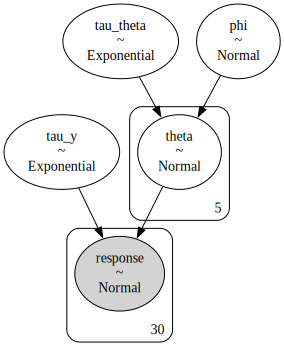

In [6]:
with pm.Model() as model_visc:
    phi = pm.Normal("phi", mu=0, sigma=1000)
    tau_theta = pm.Exponential("tau_theta", 1)
    
    tau_y = pm.Exponential("tau_y", 1)
    theta = pm.Normal("theta", mu=phi, sigma=1/tau_theta, shape=len(factors))

    y = theta[X]

    response = pm.Normal("response", mu=y, sigma=1/tau_y, observed=viscosity)

    prior_checks = pm.sample_prior_predictive(samples=200)


pm.model_to_graphviz(model_visc)

### Prior Checks for Theta

<AxesSubplot: >

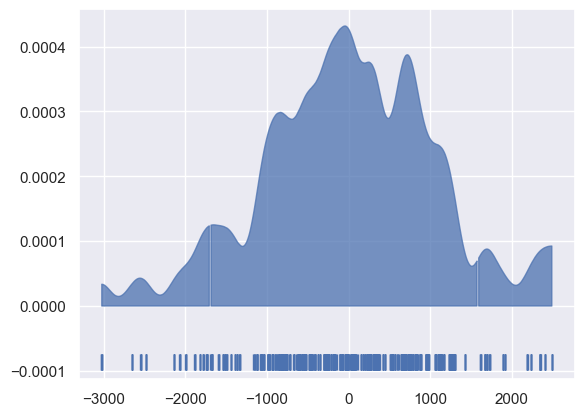

In [7]:
pm.plot_dist(prior_checks["prior"]["theta"].squeeze(), rug=True, quantiles=[0.06, 0.94])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [phi, tau_theta, tau_y, theta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


array([<AxesSubplot: title={'center': '94.0% HDI'}>], dtype=object)

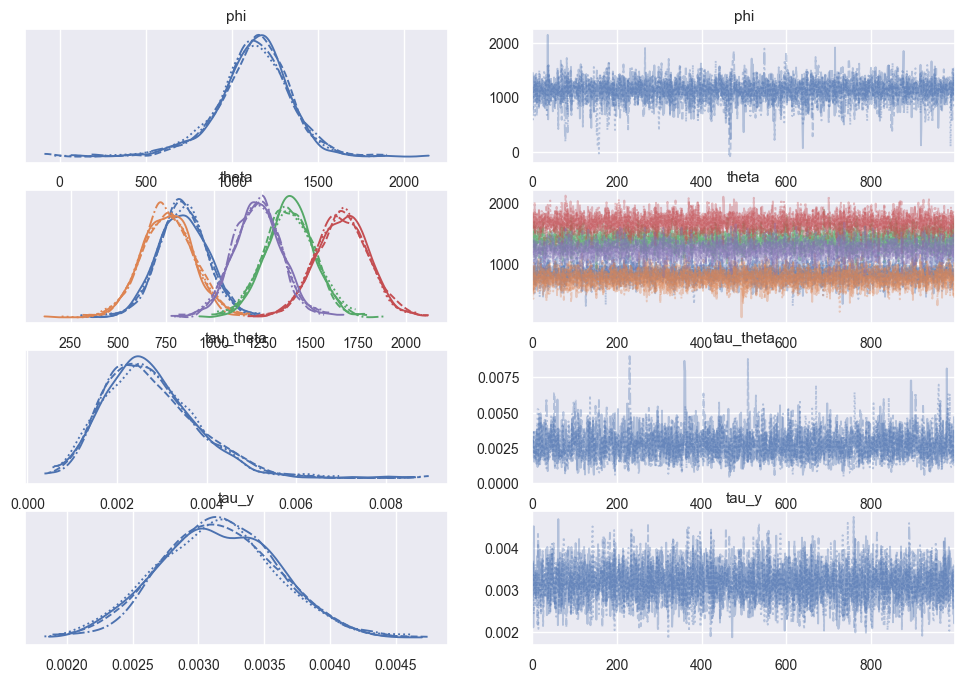

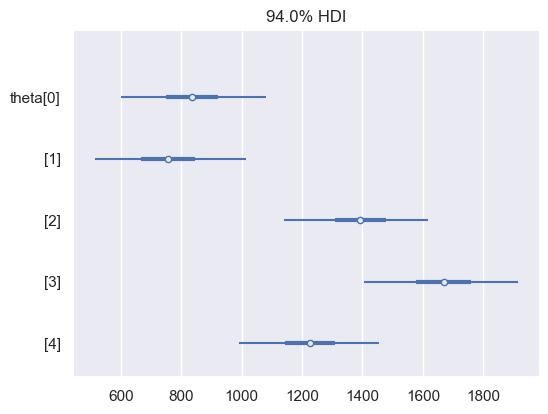

In [8]:
with model_visc:
    trace = pm.sample()
pm.plot_trace(trace)
pm.plot_forest(trace, var_names=["theta"], combined=True)

## Model Viscosity - Heterogeneous Variance
### Model Specification
Centered parameterization

$$ \phi \sim N(0, 100) , \tau_\theta \sim Exp(1) $$
$$ \theta_i \sim N(\phi, 1/\tau_\theta) $$
$$ \eta \sim Exp(1) $$
$$ \tau_{y,i} \sim Exp(\eta) $$
$$ \hat{y}_i | \theta_i, \tau_{y,i} \sim N(\theta_i, 1/\tau_{y,i})$$


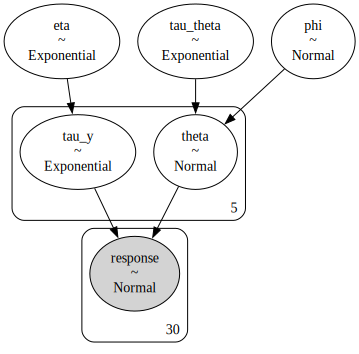

In [9]:
with pm.Model() as model_visc_2:
    phi = pm.Normal("phi", mu=0, sigma=1000)
    tau_theta = pm.Exponential("tau_theta", 1)
    theta = pm.Normal("theta", mu=phi, sigma=1/tau_theta, shape=len(factors))

    eta = pm.Exponential("eta", 1)
    tau_y = pm.Exponential("tau_y", eta, shape=len(factors))

    y = theta[X]
    sigma = 1 / tau_y[X]

    response = pm.Normal("response", mu=y, sigma=sigma, observed=viscosity)

    prior_checks = pm.sample_prior_predictive(samples=200)


pm.model_to_graphviz(model_visc_2)

<AxesSubplot: >

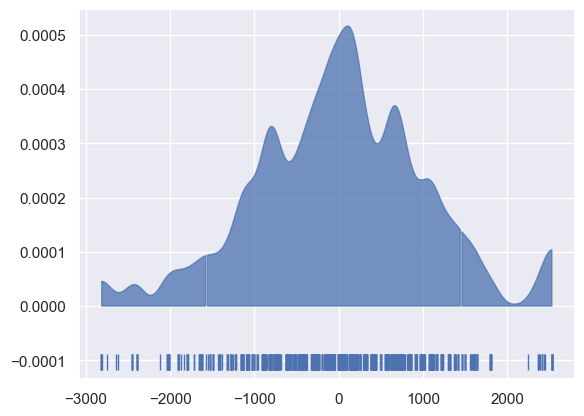

In [10]:
pm.plot_dist(prior_checks["prior"]["theta"].squeeze(), rug=True, quantiles=[0.06, 0.94])

<AxesSubplot: >

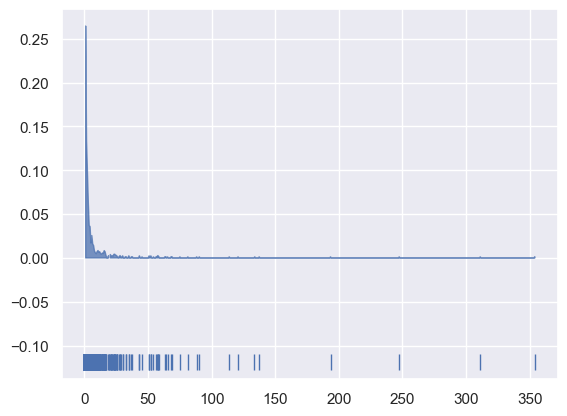

In [14]:
pm.plot_dist(prior_checks["prior"]["tau_y"].squeeze(), rug=True, quantiles=[0.06, 0.94])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [phi, tau_theta, theta, eta, tau_y]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


array([<AxesSubplot: title={'center': '94.0% HDI'}>], dtype=object)

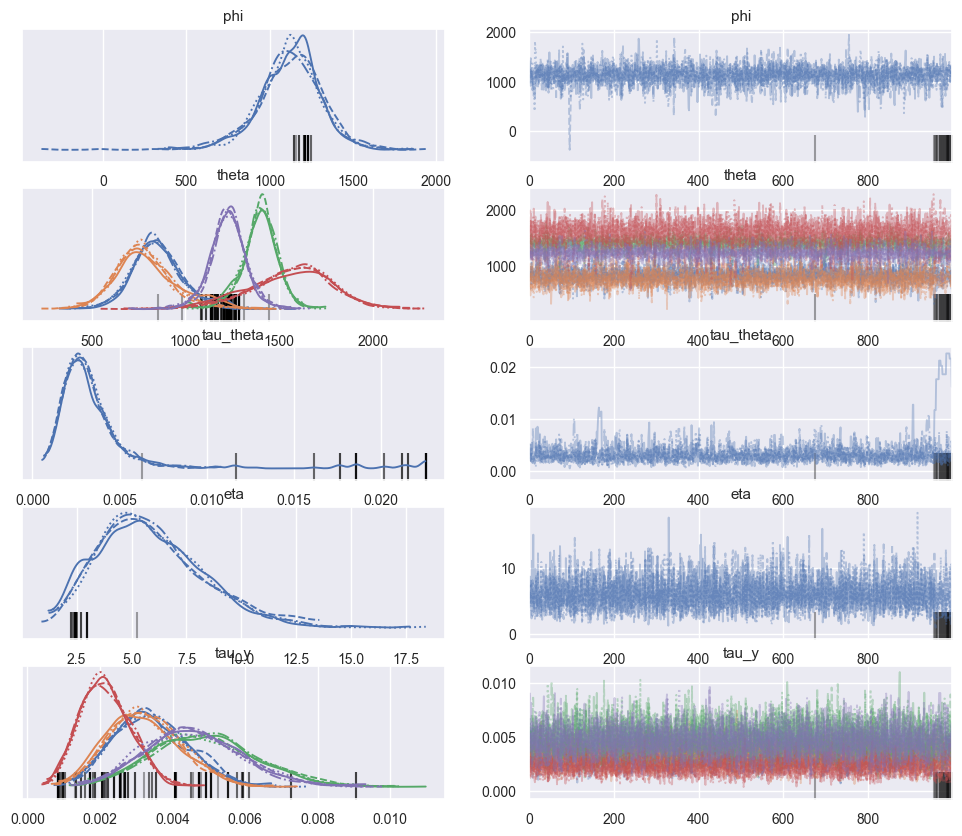

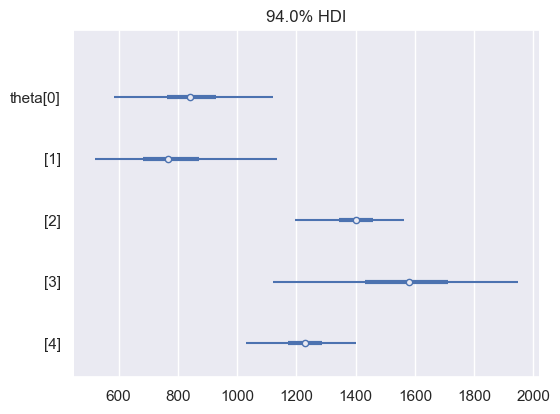

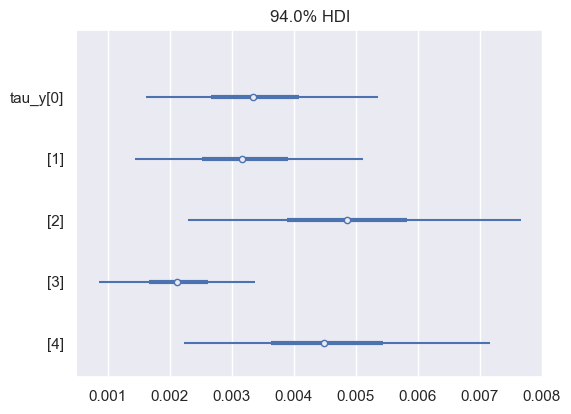

In [12]:
with model_visc_2:
    trace = pm.sample()
pm.plot_trace(trace)
pm.plot_forest(trace, var_names=["theta"], combined=True)
pm.plot_forest(trace, var_names=["tau_y"], combined=True)

array([[<AxesSubplot: title={'center': 'theta\n0'}>,
        <AxesSubplot: title={'center': 'theta\n1'}>,
        <AxesSubplot: title={'center': 'theta\n2'}>],
       [<AxesSubplot: title={'center': 'theta\n3'}>,
        <AxesSubplot: title={'center': 'theta\n4'}>, <AxesSubplot: >]],
      dtype=object)

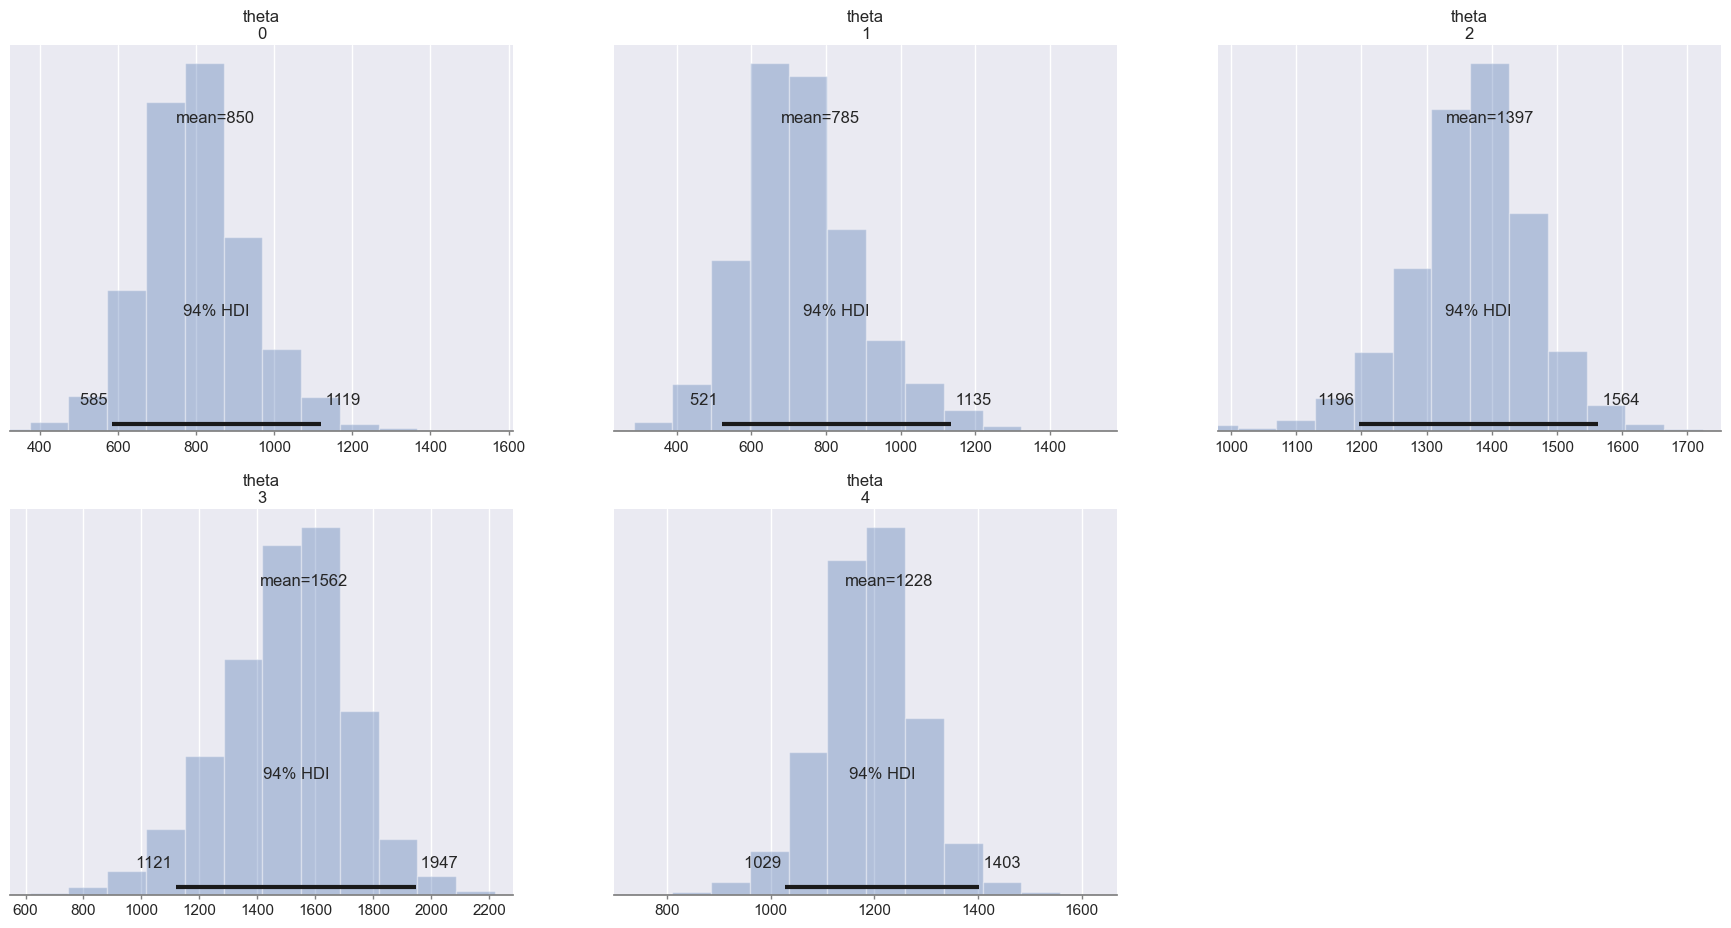

In [13]:
pm.plot_posterior(trace, var_names=["theta"], kind="hist")

## Model Viscosity - Heterogeneous Variance - Robust Estimation
### Model Specification
Centered parameterization

$$ \phi \sim N(0, 100) , \tau_\theta \sim Exp(1) $$
$$ \theta_i \sim N(\phi, 1/\tau_\theta) $$
$$ \eta \sim Exp(1) $$
$$ \tau_{y,i} \sim Exp(\eta) $$
$$ \nu \sim Exp(1/10) $$
$$ \hat{y}_i | \theta_i, \tau_{y,i}, \nu \sim StudentT(\theta_i, 1/\tau_{y,i}, \nu)$$


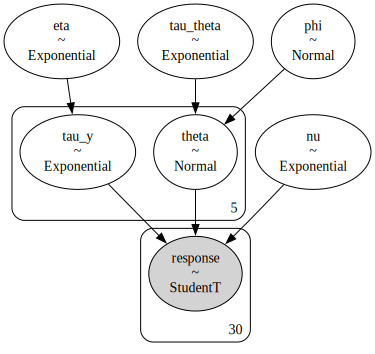

In [15]:
with pm.Model() as model_visc_robust:
    phi = pm.Normal("phi", mu=0, sigma=1000)
    tau_theta = pm.Exponential("tau_theta", 1)
    theta = pm.Normal("theta", mu=phi, sigma=1/tau_theta, shape=len(factors))

    eta = pm.Exponential("eta", 1)
    tau_y = pm.Exponential("tau_y", eta, shape=len(factors))

    y = theta[X]
    sigma = 1 / tau_y[X]

    nu = pm.Exponential("nu", 1/10)

    response = pm.StudentT("response", nu=nu, mu=y, sigma=sigma, observed=viscosity)

    prior_checks = pm.sample_prior_predictive(samples=200)


pm.model_to_graphviz(model_visc_robust)

<AxesSubplot: >

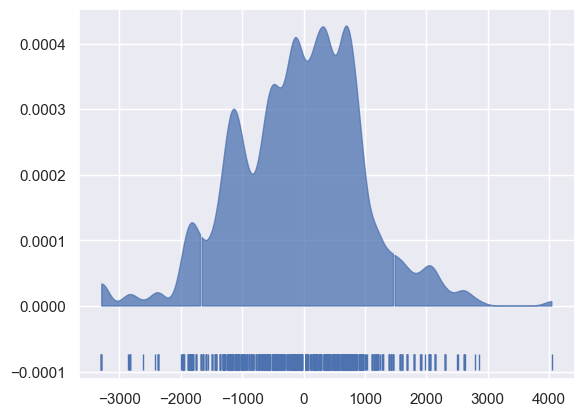

In [16]:
pm.plot_dist(prior_checks["prior"]["theta"].squeeze(), rug=True, quantiles=[0.06, 0.94])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [phi, tau_theta, theta, eta, tau_y, nu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


array([<AxesSubplot: title={'center': '94.0% HDI'}>], dtype=object)

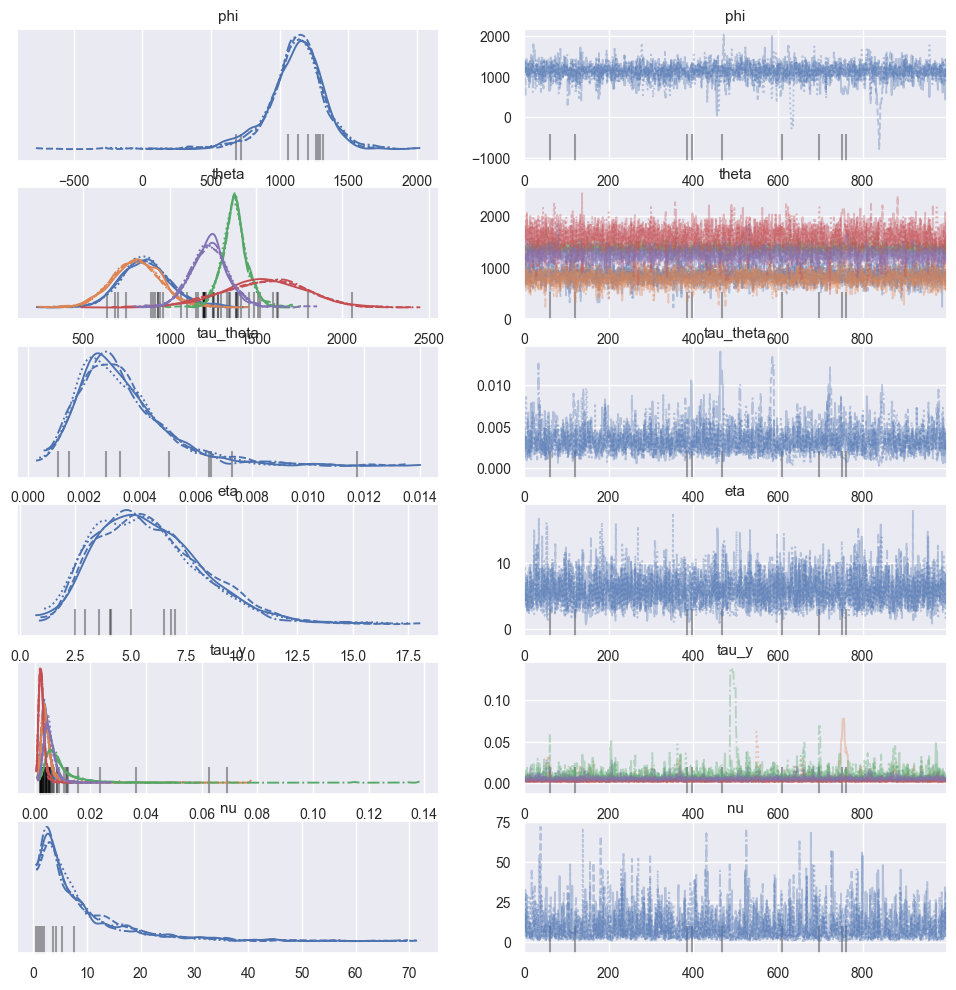

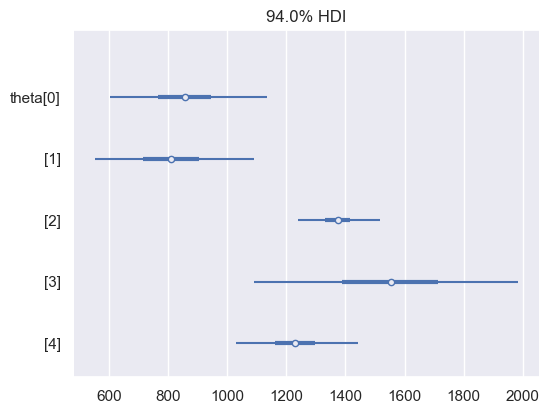

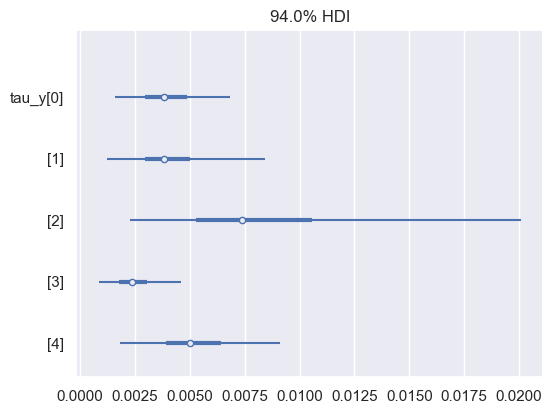

In [17]:
with model_visc_robust:
    trace = pm.sample()
pm.plot_trace(trace)
pm.plot_forest(trace, var_names=["theta"], combined=True)
pm.plot_forest(trace, var_names=["tau_y"], combined=True)

In [ ]:
## TO DO - Add a non-centered parameterization